# Import PhiFlow

In [1]:
#from phi.flow import *
from phi.torch.flow import *
import matplotlib.pyplot as plt

from src.eigenfluid import Eigenfluid
# Helper functions for visualization
from src.visu import *

import time

# Initialization Functions

In [2]:
# Domain sizes
DOMAIN = Box(x=math.PI, y=math.PI)
SAMPLING_SIZE = 20
# Number of basis fields
N = 4**2

start_time = time.time()
eigenfluid = Eigenfluid(N, DOMAIN, SAMPLING_SIZE)
end_time = time.time()
print("Eigenfluid initialized in {} seconds".format(end_time-start_time))

Eigenfluid initialized in 6.078195810317993 seconds


In [3]:
def init_smoke():
    smoke = CenteredGrid(
        Box(x=[1,2], y=[1,2]), 
        extrapolation.BOUNDARY, 
        x=100, y=100, 
        bounds=DOMAIN
    )
    return smoke

# Visualize Some Basis Fields

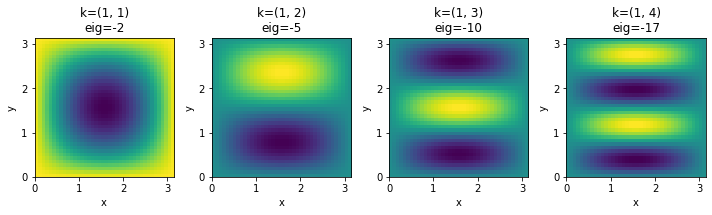

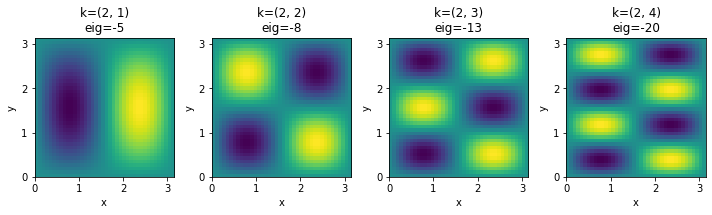

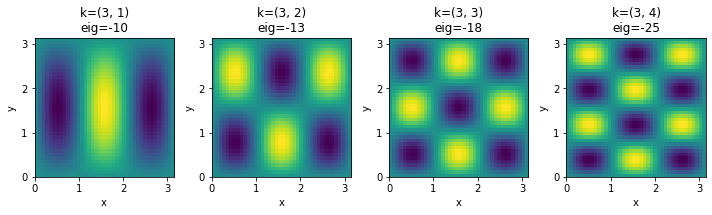

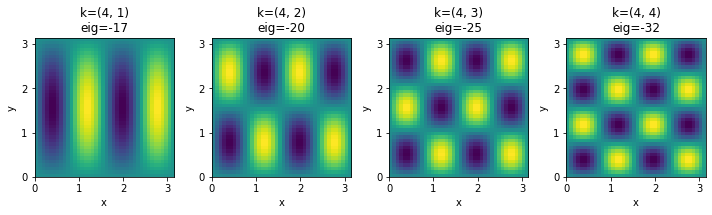

In [4]:
eigenfluid.SAMPLING_SIZE = 40

curls = []
curls_title = []

# Visualize individual velocity fields
for k in range(N):
    eigenfluid.w = tensor([1.0 if i == k else 0. for i in range(N)], eigenfluid.w.shape)
    velocity = eigenfluid.reconstruct_velocity()
    
    curls_title.append("k=({}, {})\neig={}".format(*eigenfluid.basis_fields.i[k]))
    curls.append(field.curl(velocity))

# Plot curls in NxN layout
# Note: scale is different for each plot
N_sqrt = int(math.sqrt(N))
for row in range(N_sqrt):
    plot(
        {curls_title[i]: curls[i] for i in range(N_sqrt*row, N_sqrt*row+N_sqrt)}, 
        same_scale=False,
        show_color_bar=False,
        size=(10,10)
    )

## Simulate Random Particles in Eigenfluid

*Note: each basis field is a stable position, so simulating the basis coefficients would simply yield the same velocity field over the time steps*

In [5]:
N_p = 1000
# Scatter N_p points in the domain
p = math.random_uniform(instance(i=N_p) & channel(vector='x,y'), low=0.0, high=math.PI)
p_velocities = eigenfluid.get_phi_at(p)

trajectory_p = [p]

STEPS = 256
DT = 0.05
VISCOSITY = 0.0

eigenfluid.SAMPLING_SIZE = 20

# Initialize basis coefficients w
eigenfluid.w = tensor([1.0 if i == 14 else 0. for i in range(N)], eigenfluid.w.shape)

for i in range(STEPS-1):
    # Get velocities at new positions
    p_velocities = eigenfluid.get_phi_at(p)
    # Midpoint
    p_velocities = eigenfluid.get_phi_at(p + p_velocities*DT/2)
    # Euler step for points
    p += p_velocities * DT
    # Save trajectory
    trajectory_p.append(p)

trajectory_p = math.stack(trajectory_p, batch('time'))
trajectory_curl = math.stack([field.curl(eigenfluid.reconstruct_velocity())]*STEPS, batch('time'))
trajectory_velocity = math.stack([eigenfluid.reconstruct_velocity()]*STEPS, batch('time'))

title_text = "k=({}, {})\neig={}".format(*eigenfluid.basis_fields.i[14]) 
vis.plot({
            title_text: PointCloud(trajectory_p, bounds=DOMAIN, color="black"),
            "Curl\n({})".format(title_text): trajectory_curl,
            "Velocity": trajectory_velocity
        },
        animate='time',
        #same_scale=False,
        show_color_bar=False,
        size=(9,6),
        frame_time = 10
)

<Figure size 432x288 with 0 Axes>

# Comparison with "Traditional" (grid-based) Fluid Simulation

## Run Eigenfluid Simulation

In [6]:
eigenfluid.w = eigenfluid.get_initial_w(random=True)
eigenfluid.SAMPLING_SIZE = 60

velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

trajectory_w = [eigenfluid.w]
trajectory_v_eigenfluid = [velocity]
trajectory_curl_eigenfluid = [field.curl(velocity)]
trajectory_smoke_eigenfluid = [smoke]

STEPS = 100
DT = 0.05

start_time = time.time()
for i in range(STEPS-1):
    eigenfluid.w = eigenfluid.step_w_euler(eigenfluid.w, dt=DT)
    velocity = eigenfluid.reconstruct_velocity()
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)

    trajectory_w.append(eigenfluid.w)
    trajectory_v_eigenfluid.append(velocity)
    trajectory_curl_eigenfluid.append(field.curl(velocity))
    trajectory_smoke_eigenfluid.append(smoke)
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_w = math.stack(list(map(get_w_point_cloud, [w*10 for w in trajectory_w])), batch('time'))
trajectory_v_eigenfluid = math.stack(trajectory_v_eigenfluid, batch('time'))
trajectory_curl_eigenfluid = math.stack(trajectory_curl_eigenfluid, batch('time'))
trajectory_smoke_eigenfluid = math.stack(trajectory_smoke_eigenfluid, batch('time'))

Simulation finished in 12.373387098312378 seconds


## Run Grid-Based Fluid Simulation

In [7]:
eigenfluid.w = eigenfluid.get_initial_w(random=True)
velocity = eigenfluid.reconstruct_velocity()
smoke = init_smoke()

trajectory_v_trad = [velocity]
trajectory_curl_trad = [field.curl(velocity)]
trajectory_smoke_trad = [smoke]

STEPS = 100
DT = 0.05

start_time = time.time()
for i in range(STEPS-1):
    velocity = advect.semi_lagrangian(velocity, velocity, dt=DT)
    velocity, _ = fluid.make_incompressible(velocity)
    smoke = advect.mac_cormack(smoke, velocity, dt=DT)

    trajectory_v_trad.append(velocity)
    trajectory_curl_trad.append(field.curl(velocity))
    trajectory_smoke_trad.append(smoke)
    
    
end_time = time.time()
print("Simulation finished in {} seconds".format(end_time-start_time))

trajectory_v_trad = math.stack(trajectory_v_trad, batch('time'))
trajectory_curl_trad = math.stack(trajectory_curl_trad, batch('time'))
trajectory_smoke_trad = math.stack(trajectory_smoke_trad, batch('time'))

Simulation finished in 34.0960009098053 seconds


## Plot Comparison

In [8]:
## GRID-BASED SIMULATION
vis.plot({
    "Marker Density\n(Smoke)": trajectory_smoke_trad,
    "Velocity and Curl": vis.overlay(
        trajectory_v_trad,
        trajectory_curl_trad
    )
}, animate='time', same_scale=False, size=(6,4))

<Figure size 432x288 with 0 Axes>

In [9]:
## EIGENFLUID SIMULATION
vis.plot({
    "Marker Density\n(Smoke)": trajectory_smoke_eigenfluid,
    "Velocity and Curl": vis.overlay(
        trajectory_v_eigenfluid,
        trajectory_curl_eigenfluid
    ),
    "w basis coefficients \n(*10 for visualization)": trajectory_w
}, animate='time', same_scale=False, size=(9, 4))

<Figure size 432x288 with 0 Axes>

## Show difference after 100 steps (dt=0.05)

The velocity was reconstructed on a $60\times60$ grid. Note that the eigenfluid simulation is independent of the grid resolution, and the velocity reconstructing is only an optional extra step (in this case, necessitated by the smoke simulation step).

<Figure size 864x360 with 3 Axes>

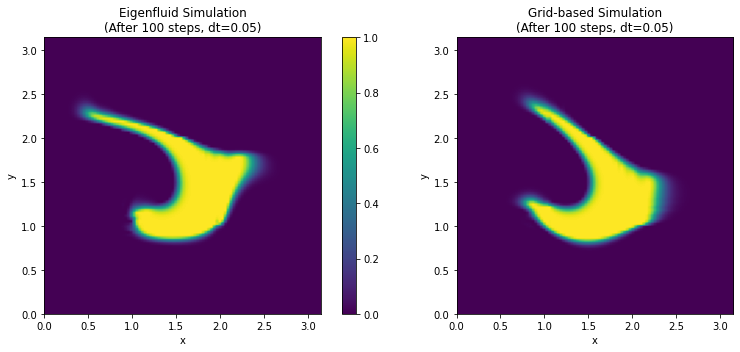

In [10]:
vis.plot({
    "Eigenfluid Simulation\n(After 100 steps, dt=0.05)": trajectory_smoke_eigenfluid.time[-1],
    "Grid-based Simulation\n(After 100 steps, dt=0.05)": trajectory_smoke_trad.time[-1]
})